In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import csv
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from operator import itemgetter
from itertools import groupby

from unsupervised_methods import *
from evaluation import *

In [2]:
datafile = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_08_09_2022_50/aerosol_data.h5'



In [3]:
def read_data(datafile):
    df = pd.read_hdf(datafile, 'df') 
    # restrict the data set to the time that start with the beginning of the first sde event and ends with end of the last sde event
    first_event_index = df['sde_event'].idxmax()
    last_event_index = df['sde_event'].where(df['sde_event']==1).last_valid_index()
    df_new = df.loc[first_event_index:last_event_index]
    #df1 = df_new[df_new.columns[1:23]]
    # delete the first column with the DateTime
    df1 = df_new[df_new.columns[1:]]
    # find the elements, where AE_SSA is negative for more than 6 hours
    AE_neg = list()
    k2 = list()
    for i in range(len(df_new['AE_SSA'])):
        if df_new['AE_SSA'].iloc[i] < 0:
            k2.append(i)
            AE_neg.append(1)
        else:
            AE_neg.append(0)
    k1 = list()
    for el in k2:
        if el+5 in k2:
            if el+4 in k2:
                if el+3 in k2:
                    if el+2 in k2:
                        if el+1 in k2:
                            k1.append(el)
    
    # Add a column, where AE_SSA is negative for more than six hours (= 1), if this is not the case (=0)
    sde_event_AE = np.zeros_like(df_new['AE_SSA'].values)
    for i in k1:
        sde_event_AE[i:i+6] = np.array([1,1,1,1,1,1])

    df1['AE_neg'] = sde_event_AE    
    SDE_events_start, SDE_events_end, df_SDE = SDE_ground_truth(df1)   
    df1 = df1.drop(['sde_event','sde_event_nr'], axis = 1)
    
 
    newnames = [x for x in df1.columns if "D" in x]
    
    newnamesD = [x for x in newnames if "V" not in x]

    newnamesV = [x for x in newnames if "V" in x]

    df1_new = df1[df1.columns[0:22]]
    df1_new['tot_V'] = df1[df1.columns[173:-1]].sum(axis =1) / (324-173)
    df1_new['tot_S'] = df1[df1.columns[23:173]].sum(axis =1) / (173-23)
    df1_new['V_smaller500'] = df1[df1.columns[204:268]].sum(axis = 1) / (268-204)
    df1_new['V_bigger500'] = df1[df1.columns[268:-1]].sum(axis = 1) / (324-268)

    df1_new['S_smaller500'] = df1[df1.columns[53:117]].sum(axis = 1) / (117-53)
    df1_new['S_bigger500'] = df1[df1.columns[117:173]].sum(axis = 1) / (173-117)

    df1_new['Vratio500']= df1_new['V_bigger500']/df1_new['tot_V']
    df1_new['Sratio500']= df1_new['S_bigger500']/df1_new['tot_S']

    #datasets:
    # whole dataset
    dataset1 = df1 
    # only optical properties
    dataset2 = df1.copy()
    dataset2 = dataset2.drop(newnamesV , axis =1)
    dataset2 = dataset2.drop(newnamesD , axis =1)
    # only size distribution properties
    dataset3 = df1.copy()
    dataset3 = dataset3[newnamesD]
    # only volume distribution properties
    dataset4 = df1.copy()
    dataset4 = dataset4[newnamesV]
    # only non optical properties
    optical = dataset2.columns
    dataset5 = df1.copy()
    dataset5 = dataset5.drop(optical, axis =1)
    # optical + size distribution
    dataset6 = df1.copy()
    dataset6 = dataset6.drop(newnamesV,axis = 1)
    # optical + volume distribution
    dataset7 = df1.copy()
    dataset7 = dataset7.drop(newnamesD, axis =1 )
    # optical + Vtot, Stot
    dataset8 = df1.copy()
    dataset8 = dataset8[optical]
    dataset8['tot_V'] = df1[df1.columns[173:-1]].sum(axis =1) / (324-173)
    dataset8['tot_S'] = df1[df1.columns[23:173]].sum(axis =1) / (173-23)
    # optical + Vsmaller500, Vbigger500, Dsmaller500, Dbigger500
    dataset9 = df1.copy()
    dataset9 = dataset9[optical]
    dataset9['V_smaller500'] = df1[df1.columns[204:268]].sum(axis = 1) / (268-204)
    dataset9['V_bigger500'] = df1[df1.columns[268:-1]].sum(axis = 1) / (324-268)
    dataset9['S_smaller500'] = df1[df1.columns[53:117]].sum(axis = 1) / (117-53)
    dataset9['S_bigger500'] = df1[df1.columns[117:173]].sum(axis = 1) / (173-117)

    # optical + Vratio500, Dratio500
    dataset10 = df1.copy()
    dataset10 = dataset10[optical]
    dataset10['V_ratio500'] = dataset9['V_bigger500']/dataset8['tot_V']
    dataset10['S_ratio500'] = dataset9['S_bigger500']/dataset8['tot_S']


    datasets = [dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8, dataset9, dataset10]
    df_dates = df_new[['DateTimeUTC','sde_event','sde_event_nr']]


    return datasets, df_dates, SDE_events_start, SDE_events_end, df_SDE

In [4]:
datasets, df_dates, SDE_events_start, SDE_events_end, df_SDE = read_data(datafile)

/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a 

In [5]:
dataset2 =datasets[1]
dataset2

N_N11  BsB_S12  BsG_S12  BsR_S12  BbsB_S12  BbsG_S12  \
2020-02-08 14:00:00  516.0     1.74     1.20     0.78      0.55      0.10   
2020-02-08 15:00:00  465.0     1.66     0.99     0.44      0.29      0.19   
2020-02-08 16:00:00  401.0     2.08     1.80     1.83      0.11      0.06   
2020-02-08 17:00:00  411.0     1.18     0.77     0.57      0.48     -0.10   
2020-02-08 18:00:00  452.0     1.27     1.17     0.76      0.17      0.01   
...                    ...      ...      ...      ...       ...       ...   
2020-11-24 23:00:00  349.0     1.08     0.98     0.90      0.18      0.08   
2020-11-25 00:00:00  355.0     0.99     0.98     0.78      0.02      0.19   
2020-11-25 01:00:00  347.0     1.53     1.25     0.48      0.04     -0.09   
2020-11-25 02:00:00  312.0     1.26     0.97     0.55      0.18     -0.07   
2020-11-25 03:00:00  300.0     1.03     1.05     0.55      0.21      0.06   

                     BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  ...  \
2020-02-08 14:00:00      0.07         0.28         0.25         0.21  ...   
2020-02-08 15:00:00      0.10         0.25         0.23         0.20  ...   
2020-02-08 16:00:00      0.46         0.28         0.24         0.19  ...   
2020-02-08 17:00:00      0.12         0.30         0.25         0.22  ...   
2020-02-08 18:00:00      0.14         0.40         0.35         0.31  ...   
...                       ...          ...          ...          ...  ...   
2020-11-24 23:00:00      0.31         0.11         0.09         0.08  ...   
2020-11-25 00:00:00      0.18         0.11         0.09         0.09  ...   
2020-11-25 01:00:00     -0.02         0.10         0.08         0.07  ...   
2020-11-25 02:00:00      0.02         0.10         0.09         0.08  ...   
2020-11-25 03:00:00      0.22         0.12         0.09         0.08  ...   

                     BaCorr1_A13       AAE  babs_450  babs_550  babs_700  \
2020-02-08 14:00:00         0.40  1.192665  0.294905  0.233823  0.195768   
2020-02-08 15:00:00         0.36  1.316928  0.264735  0.213623  0.185087   
2020-02-08 16:00:00         0.41  1.271073  0.295912  0.223485  0.167029   
2020-02-08 17:00:00         0.42  1.409532  0.318963  0.230996  0.138061   
2020-02-08 18:00:00         0.55  1.174374  0.420958  0.327688  0.270637   
...                          ...       ...       ...       ...       ...   
2020-11-24 23:00:00         0.14  0.914279  0.114461  0.085501  0.066334   
2020-11-25 00:00:00         0.15  0.986927  0.114824  0.085153  0.075487   
2020-11-25 01:00:00         0.13  0.959677  0.104261  0.075808  0.047255   
2020-11-25 02:00:00         0.12  0.909092  0.104032  0.085526  0.056875   
2020-11-25 03:00:00         0.14  0.966371  0.125150  0.085252  0.056683   

                      SSA_450   SSA_550   SSA_700    AE_SSA  AE_neg  
2020-02-08 14:00:00  0.855077  0.836923  0.799370  0.153732     0.0  
2020-02-08 15:00:00  0.862457  0.822517  0.703901  0.465966     0.0  
2020-02-08 16:00:00  0.875453  0.889554  0.916361 -0.104019     0.0  
2020-02-08 17:00:00  0.787211  0.769234  0.805015 -0.055205     0.0  
2020-02-08 18:00:00  0.751054  0.781204  0.737408  0.048076     0.0  
...                       ...       ...       ...       ...     ...  
2020-11-24 23:00:00  0.904173  0.919755  0.931355 -0.066538     0.0  
2020-11-25 00:00:00  0.896071  0.920055  0.911762 -0.036735     0.0  
2020-11-25 01:00:00  0.936203  0.942822  0.910376  0.066038     0.0  
2020-11-25 02:00:00  0.923732  0.918973  0.906282  0.043645     0.0  
2020-11-25 03:00:00  0.891659  0.924905  0.906568 -0.033522     0.0  

[6974 rows x 23 columns]

1
TP              6.000000
FN             20.000000
TN             24.000000
FP              1.000000
accuracy        0.588235
precision       0.857143
recall          0.230769
specificity     0.960000
F1              0.363636
Name: V_D0_583319, dtype: float64
2
TP             16.000000
FN             10.000000
TN             13.000000
FP             12.000000
accuracy        0.568627
precision       0.571429
recall          0.615385
specificity     0.520000
F1              0.592593
Name: BbsG_S12, dtype: float64
3
TP              6.000000
FN             20.000000
TN             24.000000
FP              1.000000
accuracy        0.588235
precision       0.857143
recall          0.230769
specificity     0.960000
F1              0.363636
Name: D0_583319, dtype: float64
4
TP              6.000000
FN             20.000000
TN             24.000000
FP              1.000000
accuracy        0.588235
precision       0.857143
recall          0.230769
specificity     0.960000
F1              0.36

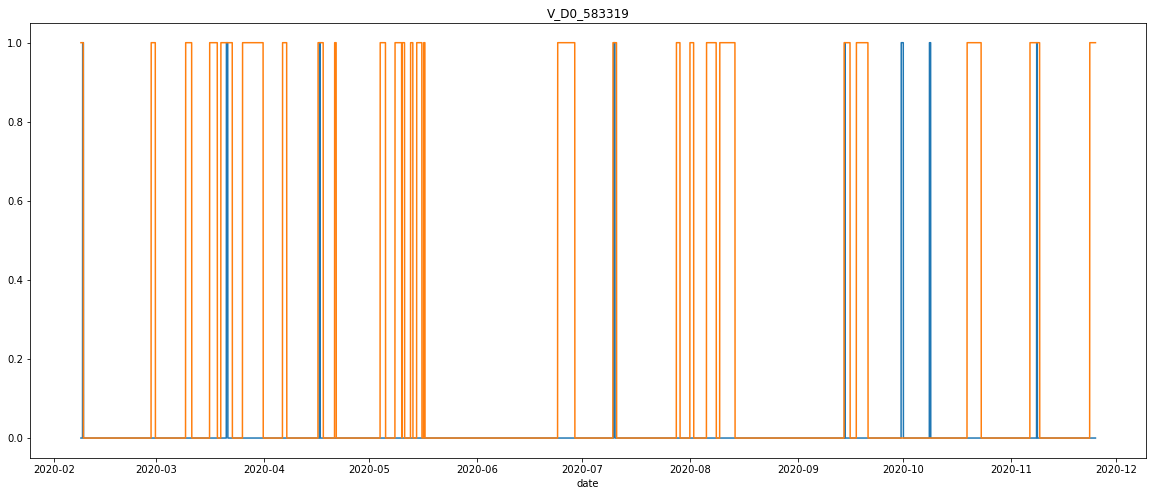

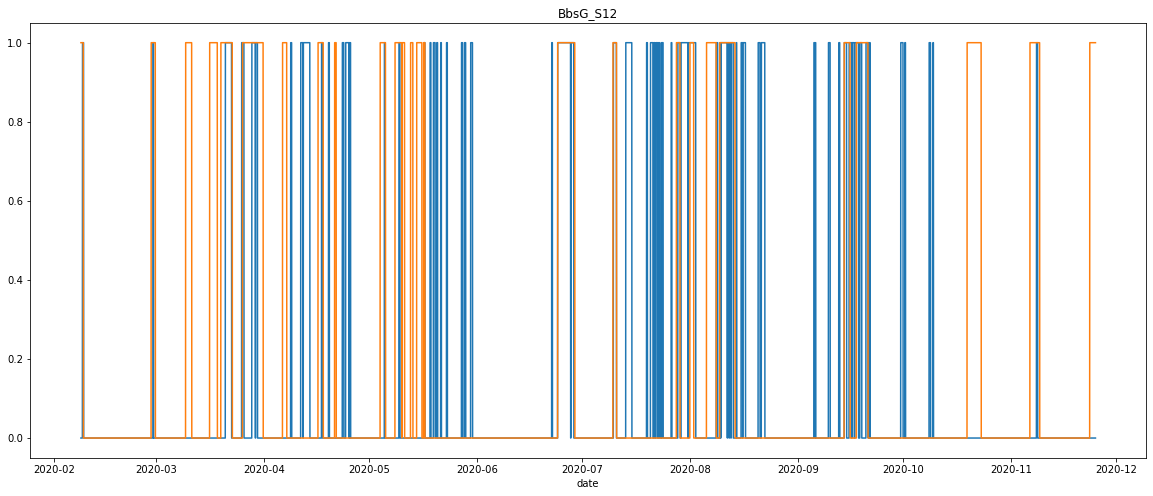

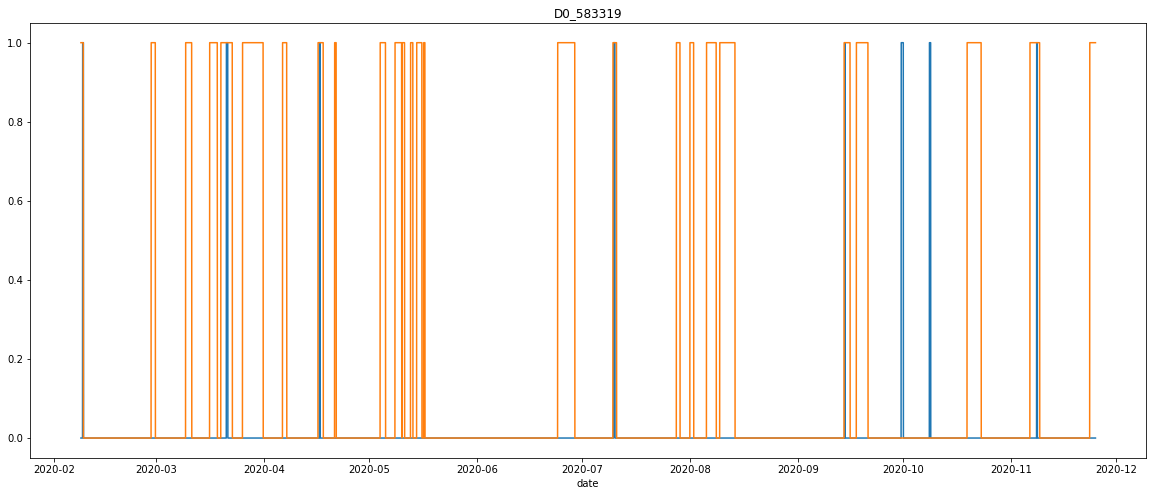

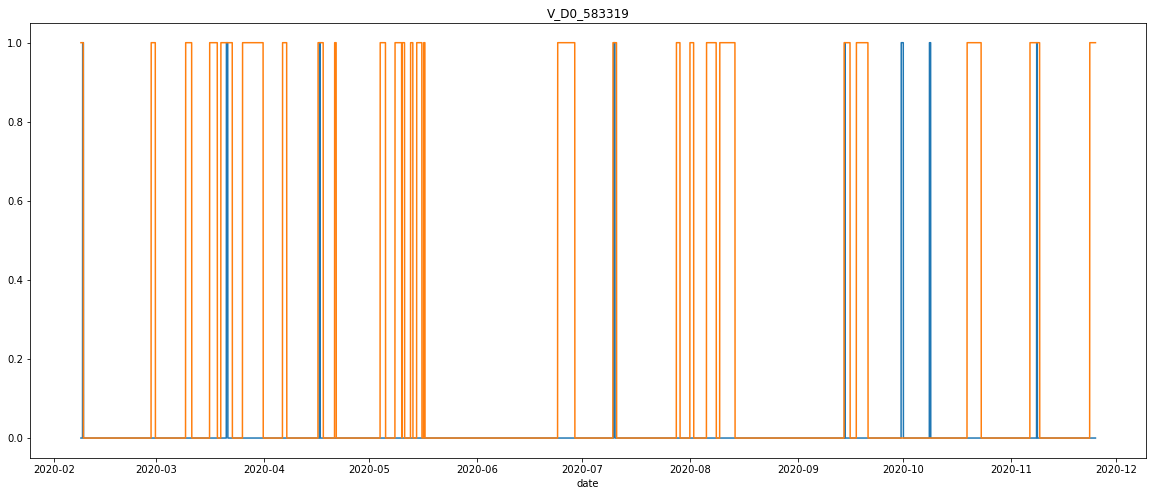

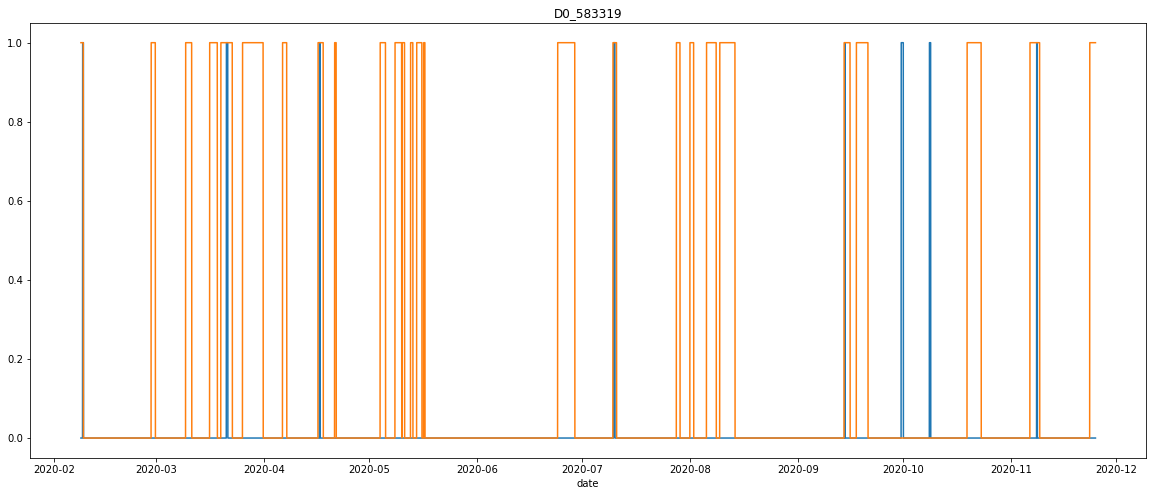

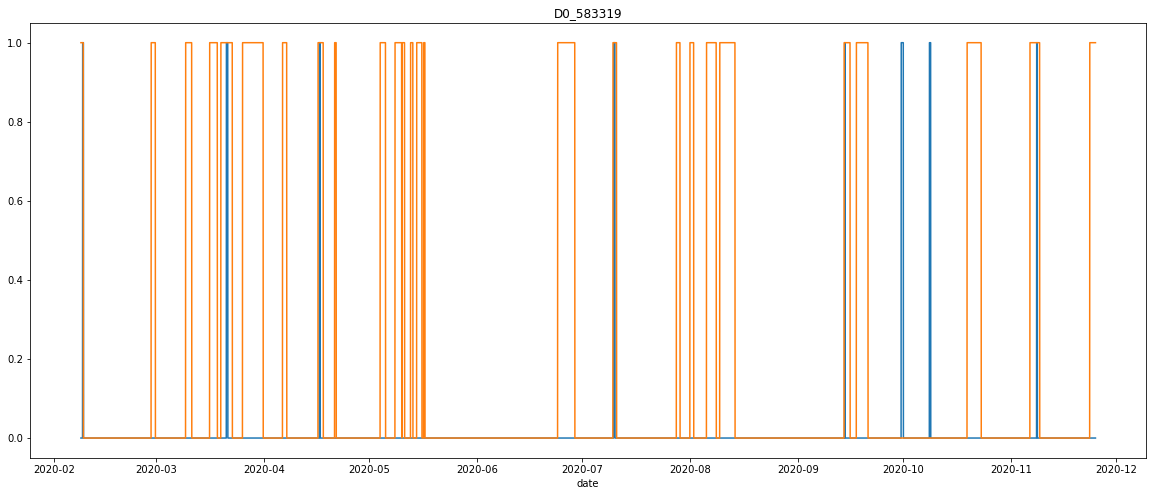

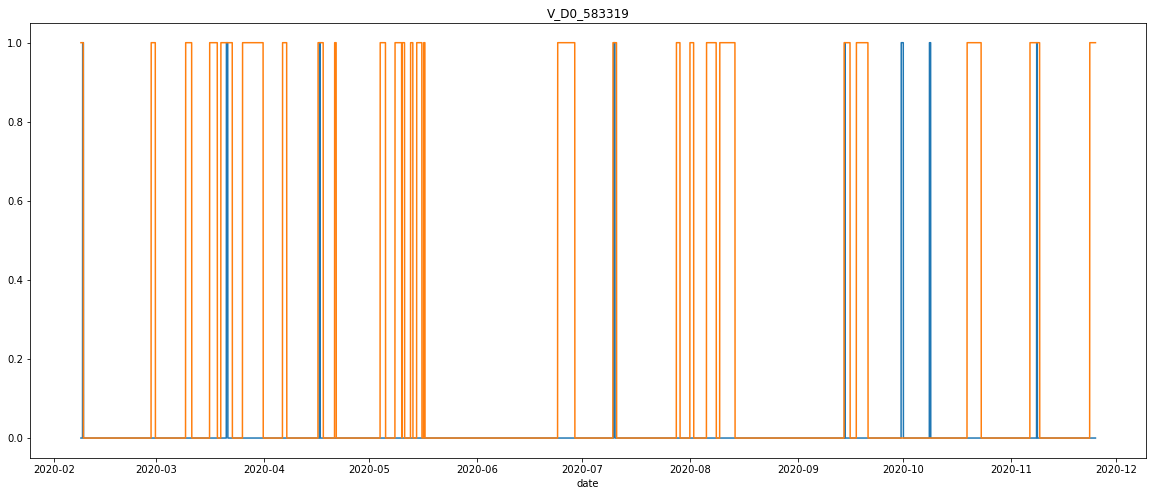

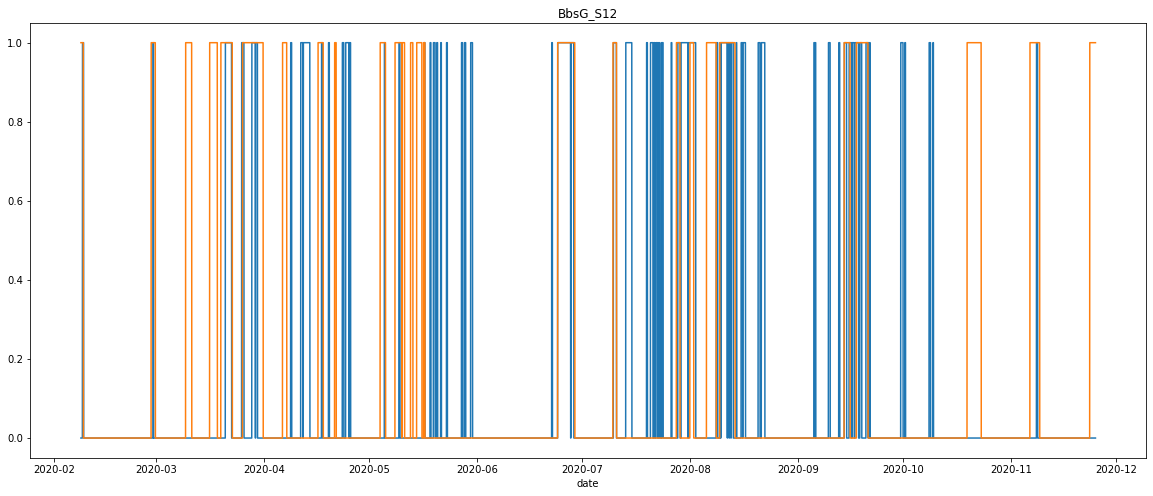

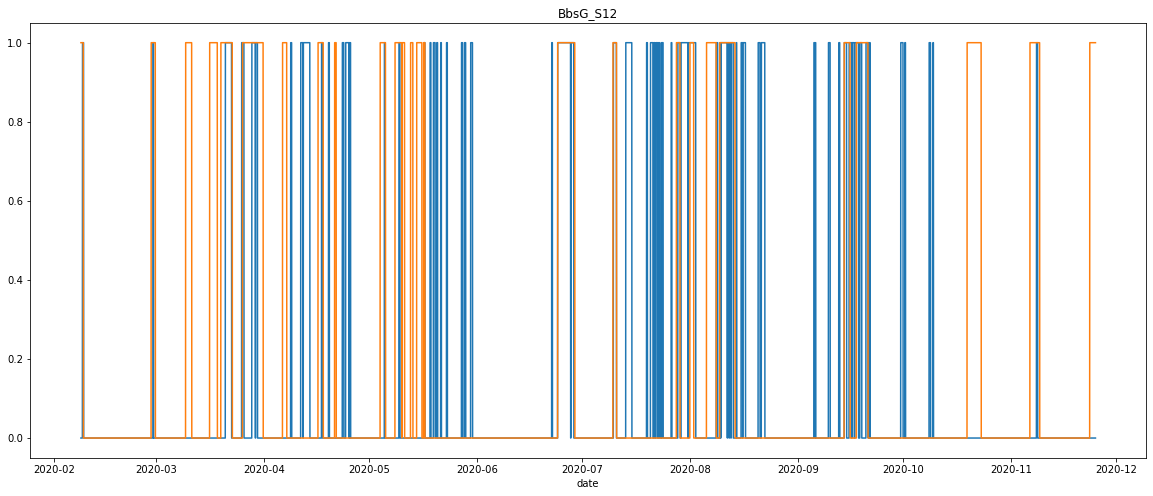

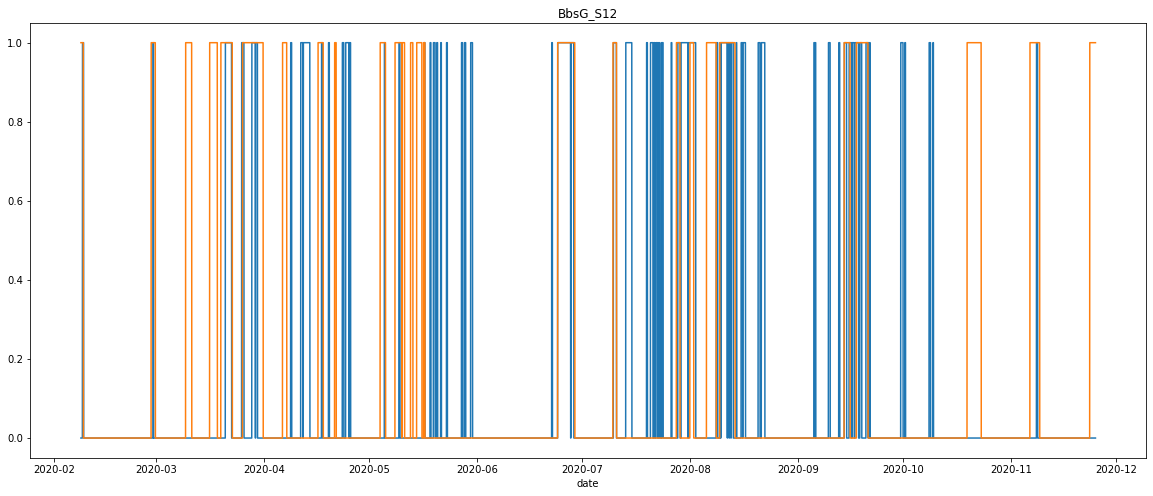

In [6]:
number = 0

dataframe_threshold = pd.DataFrame()
for df_test in datasets:
    number = number+1
    dataframe = threshold_class(df_test, df_test.max()/5.0)
    dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
    dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)
    best_result= dataframe_result.sort_values('accuracy', axis = 1, ascending = False).columns[0]
    print(number)
    print(dataframe_result[best_result])
    dataframe_threshold[str(number)+best_result] = dataframe_result[best_result]
    plt.figure(figsize = (20,8))
    plt.plot(dataframe.index, dataframe_result_plot[best_result])
    plt.plot(df_dates['DateTimeUTC'],df_dates['sde_event'])
    plt.xlabel('date')
    plt.title(best_result)

1
TP             19.000000
FN              7.000000
TN             18.000000
FP              7.000000
accuracy        0.725490
precision       0.730769
recall          0.730769
specificity     0.720000
F1              0.730769
Name: V_D4_070578, dtype: float64
2
TP             15.000000
FN             11.000000
TN             14.000000
FP             11.000000
accuracy        0.568627
precision       0.576923
recall          0.576923
specificity     0.560000
F1              0.576923
Name: BsR_S12, dtype: float64
3
TP             20.000000
FN              6.000000
TN             17.000000
FP              8.000000
accuracy        0.725490
precision       0.714286
recall          0.769231
specificity     0.680000
F1              0.740741
Name: D3_280243, dtype: float64
4
TP             20.000000
FN              6.000000
TN             17.000000
FP              8.000000
accuracy        0.725490
precision       0.714286
recall          0.769231
specificity     0.680000
F1              0.740

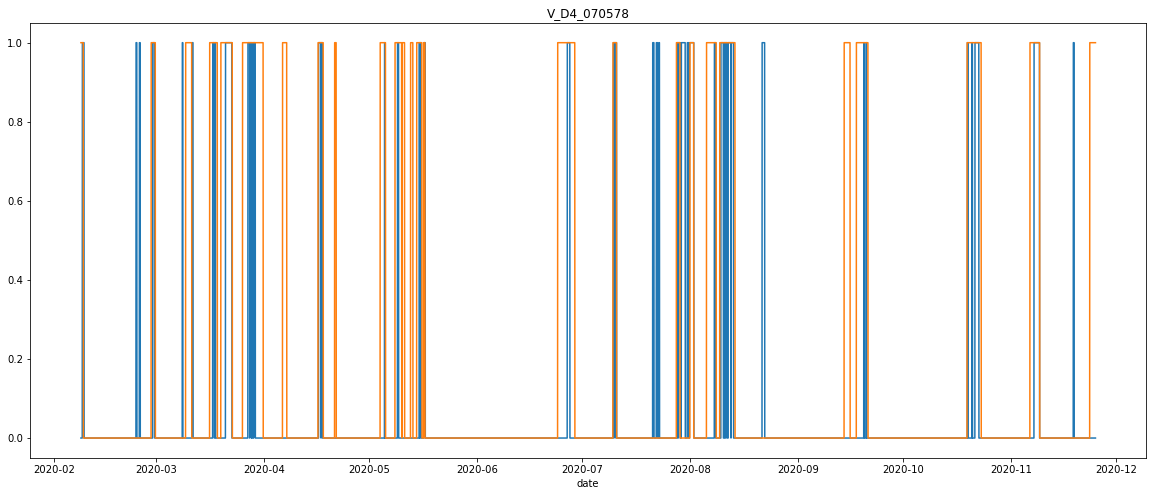

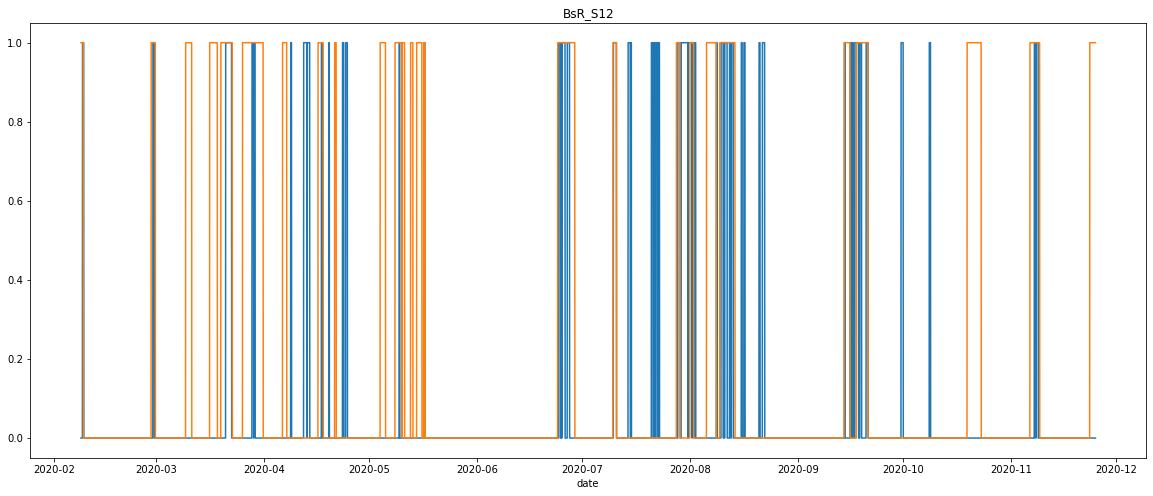

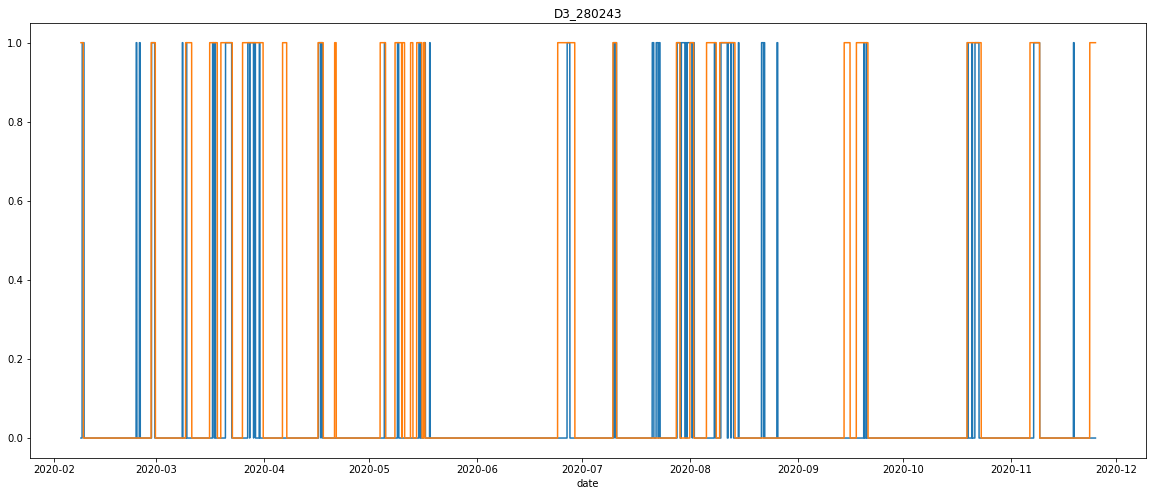

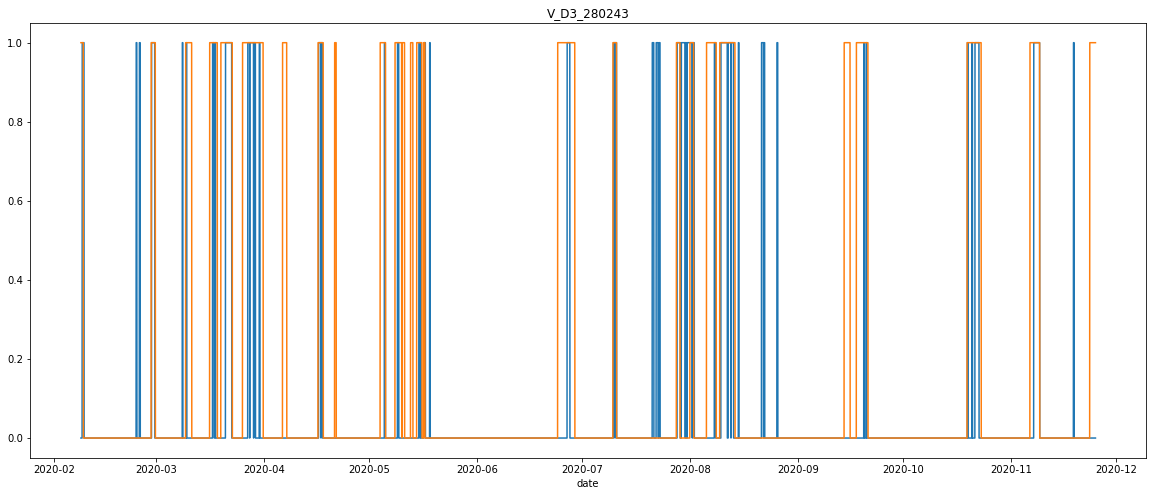

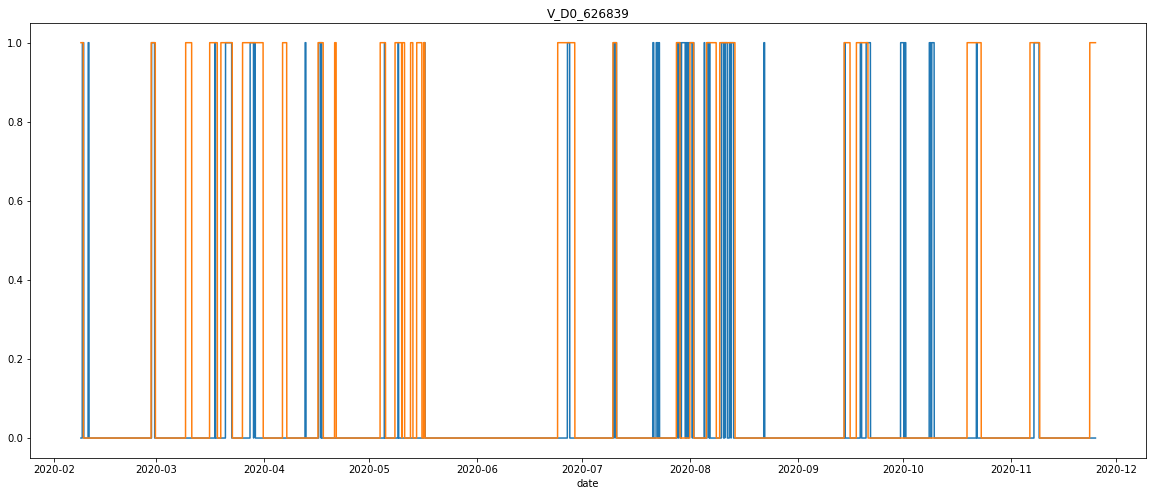

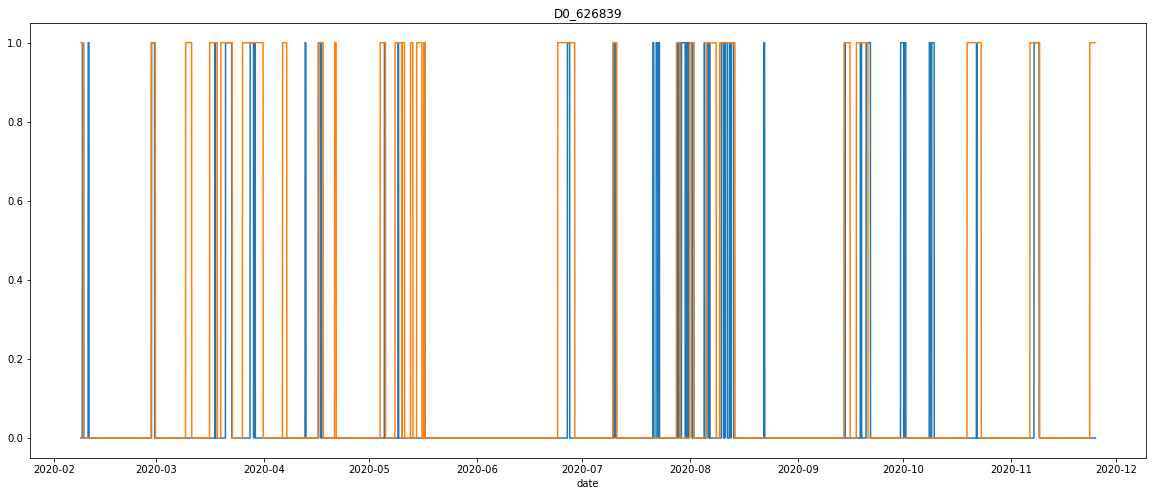

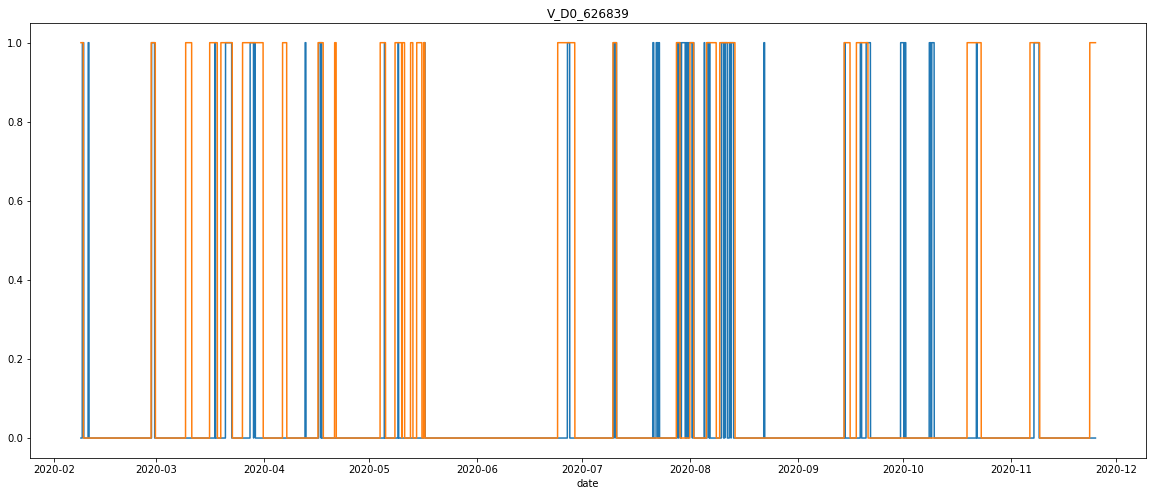

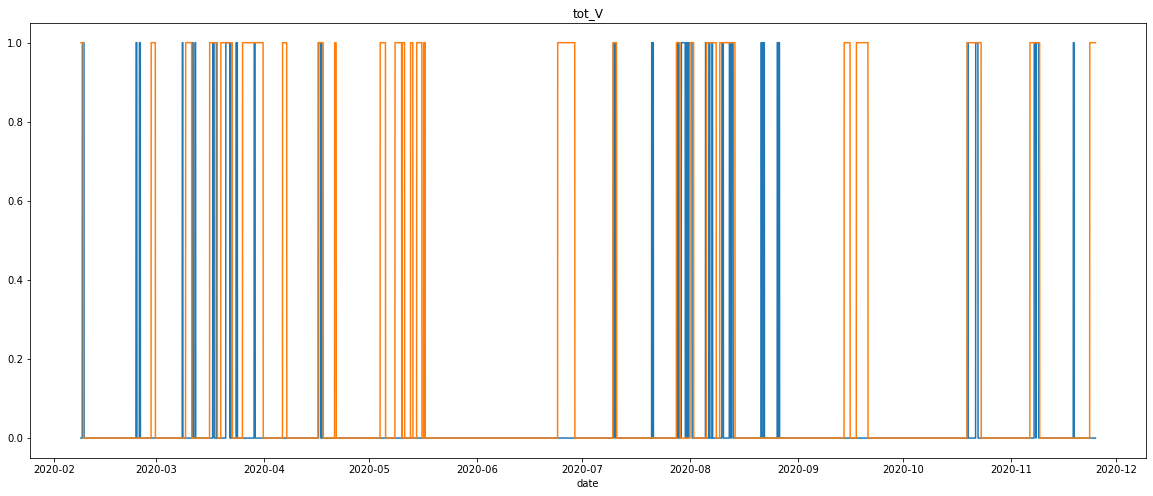

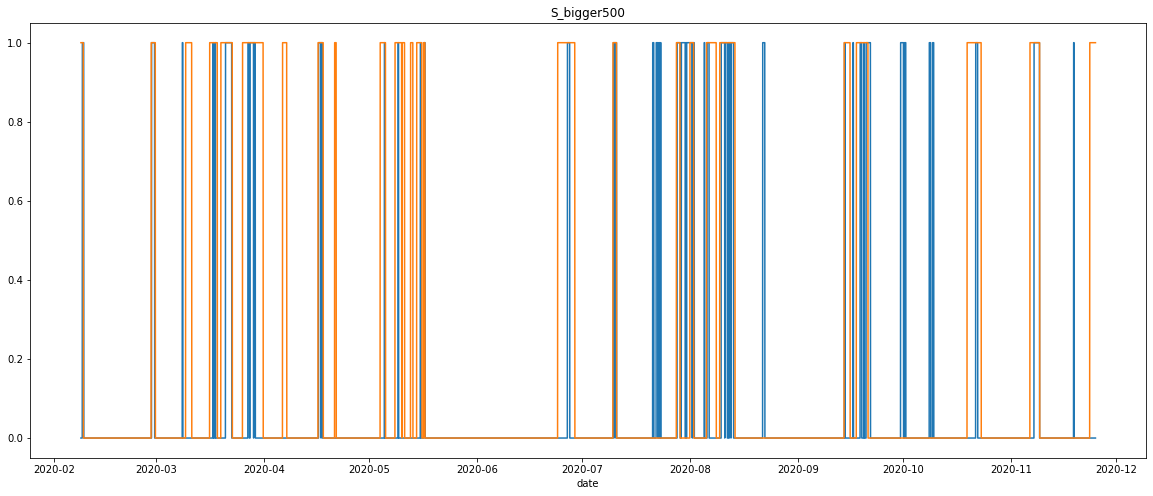

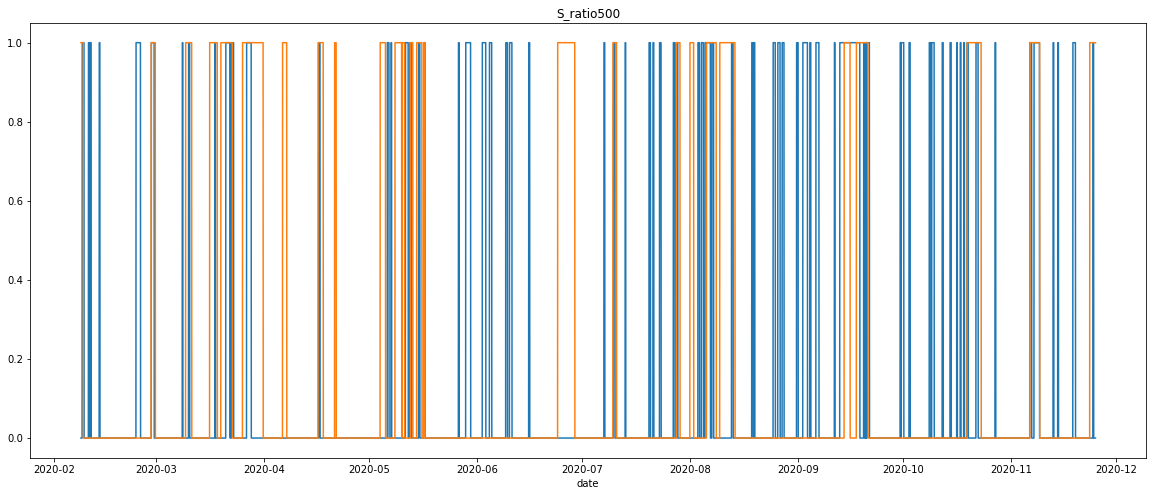

In [7]:
number = 0
dataframe_interquartile = pd.DataFrame()
for df_test in datasets:
    number = number+1
    dataframe = interquartile_class(df_test)
    dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
    dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)
    best_result= dataframe_result.sort_values('accuracy', axis = 1, ascending = False).columns[0]
    print(number)
    print(dataframe_result[best_result])
    dataframe_interquartile[str(number)+best_result] = dataframe_result[best_result]
    plt.figure(figsize = (20,8))
    plt.plot(dataframe.index, dataframe_result_plot[best_result])
    plt.plot(df_dates['DateTimeUTC'],df_dates['sde_event'])
    plt.xlabel('date')
    plt.title(best_result)

In [8]:
df_results5, dataframe_pred5 = classification_results('LOF', dataset2,df_dates, Multivariate = True)
df_results5

0
#sde_truth     26.000000
#nosde_truth   25.000000
#sde_pred     101.000000
#nosde_pred   102.000000
TP             18.000000
FN              8.000000
TN              9.000000
FP             16.000000
accuracy        0.529412
precision       0.529412
recall          0.692308
specificity     0.360000
F1              0.600000

In [9]:
df_results4, dataframe_pred4 = classification_results('OCSVM_SGD', dataset2,df_dates, Multivariate = True)
df_results4

0
#sde_truth    26.000000
#nosde_truth  25.000000
#sde_pred     60.000000
#nosde_pred   61.000000
TP            12.000000
FN            14.000000
TN             8.000000
FP            17.000000
accuracy       0.392157
precision      0.413793
recall         0.461538
specificity    0.320000
F1             0.436364

In [10]:
df_results3, dataframe_pred3 = classification_results('OCSVM', dataset2,df_dates, Multivariate = True)
df_results3

0
#sde_truth     26.000000
#nosde_truth   25.000000
#sde_pred     198.000000
#nosde_pred   198.000000
TP             20.000000
FN              6.000000
TN              4.000000
FP             21.000000
accuracy        0.470588
precision       0.487805
recall          0.769231
specificity     0.160000
F1              0.597015

In [11]:
dataframe_pred3[dataframe_pred3['sde_event_predicted_nr']==89]

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
2020-06-29 00:00:00          1                    1                         0   
2020-06-29 01:00:00          1                    1                         0   
2020-06-29 02:00:00          1                    1                         0   
2020-06-29 03:00:00          1                    1                         0   
2020-06-29 04:00:00          1                    1                         0   
2020-06-29 05:00:00          1                    1                         0   
2020-06-29 06:00:00          1                    1                         0   
2020-06-29 07:00:00          1                    1                         0   
2020-06-29 08:00:00          1                    1                         0   
2020-06-29 09:00:00          1                    1                         0   
2020-06-29 10:00:00          1                    1                         0   

                     sde_event_predicted_nr  
2020-06-29 00:00:00                      89  
2020-06-29 01:00:00                      89  
2020-06-29 02:00:00                      89  
2020-06-29 03:00:00                      89  
2020-06-29 04:00:00                      89  
2020-06-29 05:00:00                      89  
2020-06-29 06:00:00                      89  
2020-06-29 07:00:00                      89  
2020-06-29 08:00:00                      89  
2020-06-29 09:00:00                      89  
2020-06-29 10:00:00                      89

In [12]:
df_results2, dataframe_pred2 = classification_results('isolation_forest', dataset2,df_dates, Multivariate = True)
df_results2

0
#sde_truth     26.000000
#nosde_truth   25.000000
#sde_pred     137.000000
#nosde_pred   136.000000
TP             25.000000
FN              1.000000
TN              0.000000
FP             25.000000
accuracy        0.490196
precision       0.500000
recall          0.961538
specificity     0.000000
F1              0.657895

In [13]:
df_results1, dataframe_pred1 = classification_results('kmeans', dataset2,df_dates, Multivariate = True)
df_results1

0
#sde_truth    26.000000
#nosde_truth  25.000000
#sde_pred     90.000000
#nosde_pred   91.000000
TP            16.000000
FN            10.000000
TN             6.000000
FP            19.000000
accuracy       0.431373
precision      0.457143
recall         0.615385
specificity    0.240000
F1             0.524590

In [166]:
def classification_results_1(method, dataset,df_dates, Multivariate ):
    multiv = Multivariate
    if method == 'kmeans':
        dataframe = kmeans_class(dataset, multivariate=multiv)
    elif method == 'isolation_forest':
        dataframe = isolationforest_class(dataset, multivariate = multiv)
    elif method == 'OCSVM':
        dataframe = OCSVM_class(dataset, multivariate = multiv)
    elif method == 'OCSVM_SGD':
        dataframe = OCSVM_SGD_class(dataset, multivariate = multiv)
    elif method == 'LOF':
        dataframe = LocalOutlierFactor_class(dataset, multivariate = multiv)
        
    dataframe_pred = compute_dust_events(dataframe, multivariate = multiv)
    df_dates_new = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    dataframe_pred = number_noevents_data(dataframe_pred, 'nosde_event_predicted_nr', 'sde_event_predicted_nr', multivariate = multiv)
    result = metric_sde(df_dates_new, dataframe_pred)

    result_acc = acc_prec_rec(result)
            
    return result_acc, dataframe_pred



In [172]:
test1 = classification_results_1('kmeans', dataset2,df_dates, Multivariate = False)

['sde_eventN_N11predicted', 'sde_eventBsB_S12predicted', 'sde_eventBsG_S12predicted', 'sde_eventBsR_S12predicted', 'sde_eventBbsB_S12predicted', 'sde_eventBbsG_S12predicted', 'sde_eventBbsR_S12predicted', 'sde_eventBaCorr2_A13predicted', 'sde_eventBaCorr3_A13predicted', 'sde_eventBaCorr4_A13predicted', 'sde_eventBaCorr5_A13predicted', 'sde_eventBaCorr6_A13predicted', 'sde_eventBaCorr7_A13predicted', 'sde_eventBaCorr1_A13predicted', 'sde_eventAAEpredicted', 'sde_eventbabs_450predicted', 'sde_eventbabs_550predicted', 'sde_eventbabs_700predicted', 'sde_eventSSA_450predicted', 'sde_eventSSA_550predicted', 'sde_eventSSA_700predicted', 'sde_eventAE_SSApredicted', 'sde_eventAE_negpredicted']
sde_eventN_N11predicted
sde_eventBsB_S12predicted
sde_eventBsG_S12predicted
sde_eventBsR_S12predicted
sde_eventBbsB_S12predicted
sde_eventBbsG_S12predicted
sde_eventBbsR_S12predicted
sde_eventBaCorr2_A13predicted
sde_eventBaCorr3_A13predicted
sde_eventBaCorr4_A13predicted
sde_eventBaCorr5_A13predicted
sde

KeyError: 'sde_event_predicted'

In [168]:
test1

''

In [25]:
dataframe = kmeans_class(dataset2, multivariate = False)

In [26]:
dataframe

sde_eventN_N11  sde_eventBsB_S12  sde_eventBsG_S12  \
2020-02-08 14:00:00               0                 0                 0   
2020-02-08 15:00:00               0                 0                 0   
2020-02-08 16:00:00               0                 0                 0   
2020-02-08 17:00:00               0                 0                 0   
2020-02-08 18:00:00               0                 0                 0   
...                             ...               ...               ...   
2020-11-24 23:00:00               0                 0                 0   
2020-11-25 00:00:00               0                 0                 0   
2020-11-25 01:00:00               0                 0                 0   
2020-11-25 02:00:00               0                 0                 0   
2020-11-25 03:00:00               0                 0                 0   

                     sde_eventBsR_S12  sde_eventBbsB_S12  sde_eventBbsG_S12  \
2020-02-08 14:00:00                 0                  0                  0   
2020-02-08 15:00:00                 0                  0                  0   
2020-02-08 16:00:00                 0                  0                  0   
2020-02-08 17:00:00                 0                  0                  1   
2020-02-08 18:00:00                 0                  0                  0   
...                               ...                ...                ...   
2020-11-24 23:00:00                 0                  0                  0   
2020-11-25 00:00:00                 0                  0                  0   
2020-11-25 01:00:00                 0                  0                  1   
2020-11-25 02:00:00                 0                  0                  1   
2020-11-25 03:00:00                 0                  0                  0   

                     sde_eventBbsR_S12  sde_eventBaCorr2_A13  \
2020-02-08 14:00:00                  0                     0   
2020-02-08 15:00:00                  0                     0   
2020-02-08 16:00:00                  0                     0   
2020-02-08 17:00:00                  0                     0   
2020-02-08 18:00:00                  0                     0   
...                                ...                   ...   
2020-11-24 23:00:00                  0                     0   
2020-11-25 00:00:00                  0                     0   
2020-11-25 01:00:00                  1                     0   
2020-11-25 02:00:00                  0                     0   
2020-11-25 03:00:00                  0                     0   

                     sde_eventBaCorr3_A13  sde_eventBaCorr4_A13  ...  \
2020-02-08 14:00:00                     0                     0  ...   
2020-02-08 15:00:00                     0                     0  ...   
2020-02-08 16:00:00                     0                     0  ...   
2020-02-08 17:00:00                     0                     0  ...   
2020-02-08 18:00:00                     0                     0  ...   
...                                   ...                   ...  ...   
2020-11-24 23:00:00                     0                     0  ...   
2020-11-25 00:00:00                     0                     0  ...   
2020-11-25 01:00:00                     0                     0  ...   
2020-11-25 02:00:00                     0                     0  ...   
2020-11-25 03:00:00                     0                     0  ...   

                     sde_eventBaCorr1_A13  sde_eventAAE  sde_eventbabs_450  \
2020-02-08 14:00:00                     0             0                  0   
2020-02-08 15:00:00                     0             1                  0   
2020-02-08 16:00:00                     0             1                  0   
2020-02-08 17:00:00                     0             1                  0   
2020-02-08 18:00:00                     0             0                  0   
...                                   ...           ...              

In [169]:
def compute_dust_events(dataframe, multivariate = True):
    if multivariate == True:
        dataframe1 = list()
        k2 = list()
        for i in range(len(dataframe['sde_event'])):
            if dataframe['sde_event'].iloc[i]>=0.5:
                k2.append(i)

        k1 = list()
        for el in k2:
            if el+3 in k2:
                if el+2 in k2:
                    if el+1 in k2:
                        k1.append(el)        
        sde_event_1s = np.zeros_like(dataframe['sde_event'].values)

        for j in k1:
            sde_event_1s[j:j+4]=np.array([1,1,1,1])

        dataframe['sde_event_predicted']=sde_event_1s
        return dataframe        

    else:  
        for col in dataframe.columns:
            dataframe1 = list()
            k2 = list()
            for i in range(len(dataframe[col])):
                if dataframe[col].iloc[i]>=0.5:
                    k2.append(i)

            k1 = list()
            for el in k2:
                if el+3 in k2:
                    if el+2 in k2:
                        if el+1 in k2:
                            k1.append(el)        
            sde_event_1s = np.zeros_like(dataframe[col].values)

            for j in k1:
                sde_event_1s[j:j+4]=np.array([1,1,1,1])

            dataframe[col+'predicted']=sde_event_1s

        return dataframe

In [28]:
dataframe_pred = compute_dust_events(dataframe, multivariate = False)

In [29]:
dataframe_pred

sde_eventN_N11  sde_eventBsB_S12  sde_eventBsG_S12  \
2020-02-08 14:00:00               0                 0                 0   
2020-02-08 15:00:00               0                 0                 0   
2020-02-08 16:00:00               0                 0                 0   
2020-02-08 17:00:00               0                 0                 0   
2020-02-08 18:00:00               0                 0                 0   
...                             ...               ...               ...   
2020-11-24 23:00:00               0                 0                 0   
2020-11-25 00:00:00               0                 0                 0   
2020-11-25 01:00:00               0                 0                 0   
2020-11-25 02:00:00               0                 0                 0   
2020-11-25 03:00:00               0                 0                 0   

                     sde_eventBsR_S12  sde_eventBbsB_S12  sde_eventBbsG_S12  \
2020-02-08 14:00:00                 0                  0                  0   
2020-02-08 15:00:00                 0                  0                  0   
2020-02-08 16:00:00                 0                  0                  0   
2020-02-08 17:00:00                 0                  0                  1   
2020-02-08 18:00:00                 0                  0                  0   
...                               ...                ...                ...   
2020-11-24 23:00:00                 0                  0                  0   
2020-11-25 00:00:00                 0                  0                  0   
2020-11-25 01:00:00                 0                  0                  1   
2020-11-25 02:00:00                 0                  0                  1   
2020-11-25 03:00:00                 0                  0                  0   

                     sde_eventBbsR_S12  sde_eventBaCorr2_A13  \
2020-02-08 14:00:00                  0                     0   
2020-02-08 15:00:00                  0                     0   
2020-02-08 16:00:00                  0                     0   
2020-02-08 17:00:00                  0                     0   
2020-02-08 18:00:00                  0                     0   
...                                ...                   ...   
2020-11-24 23:00:00                  0                     0   
2020-11-25 00:00:00                  0                     0   
2020-11-25 01:00:00                  1                     0   
2020-11-25 02:00:00                  0                     0   
2020-11-25 03:00:00                  0                     0   

                     sde_eventBaCorr3_A13  sde_eventBaCorr4_A13  ...  \
2020-02-08 14:00:00                     0                     0  ...   
2020-02-08 15:00:00                     0                     0  ...   
2020-02-08 16:00:00                     0                     0  ...   
2020-02-08 17:00:00                     0                     0  ...   
2020-02-08 18:00:00                     0                     0  ...   
...                                   ...                   ...  ...   
2020-11-24 23:00:00                     0                     0  ...   
2020-11-25 00:00:00                     0                     0  ...   
2020-11-25 01:00:00                     0                     0  ...   
2020-11-25 02:00:00                     0                     0  ...   
2020-11-25 03:00:00                     0                     0  ...   

                     sde_eventBaCorr1_A13predicted  sde_eventAAEpredicted  \
2020-02-08 14:00:00                              0                      0   
2020-02-08 15:00:00                              0                      0   
2020-02-08 16:00:00                              0                      0   
2020-02-08 17:00:00                              0                      0   
2020-02-08 18:00:00                              0                      0   
...                                            ...                    ...  

In [50]:
dataframe_pred1 = dataframe_pred[['sde_eventN_N11', 'sde_eventN_N11predicted']]
dataframe_pred1

sde_eventN_N11  sde_eventN_N11predicted
2020-02-08 14:00:00               0                        0
2020-02-08 15:00:00               0                        0
2020-02-08 16:00:00               0                        0
2020-02-08 17:00:00               0                        0
2020-02-08 18:00:00               0                        0
...                             ...                      ...
2020-11-24 23:00:00               0                        0
2020-11-25 00:00:00               0                        0
2020-11-25 01:00:00               0                        0
2020-11-25 02:00:00               0                        0
2020-11-25 03:00:00               0                        0

[6974 rows x 2 columns]

In [51]:
def number_noevents_data(dataframe, noevent_col, event_col, multivariate = True):
    if multivariate == True:
        event_name = 'sde_event_predicted'
        num_nosde = 0
        num_sde = 0
        dataframe.loc[:,noevent_col]=0
        dataframe.loc[:,event_col]=0
        for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
            if v[event_name].all() ==0:
               # dataframe[noevent_col].loc[v.index]=num_nosde
                dataframe.loc[v.index, noevent_col]=num_nosde
                num_nosde = num_nosde+1
            if v[event_name].all() ==1:
               # dataframe[event_col].loc[v.index]=num_sde
                dataframe.loc[v.index, event_col]=num_sde
                num_sde = num_sde+1

    else:
        event_columns = [x for x in dataframe.columns if 'predicted' in x]
        print(event_columns)
        for col_names in event_columns:
            print(col_names)
            num_nosde = 0
            num_sde = 0
            noevent_col = 'no_'+col_names+'_nr'
            event_col = col_names+'_nr'
            dataframe.loc[:,noevent_col]=0
            dataframe.loc[:,event_col]=0
            event_name = col_names
            for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
                if v[event_name].all() ==0:
                    dataframe.loc[v.index, noevent_col]=num_nosde
                    num_nosde = num_nosde+1
                if v[event_name].all() ==1:
                   # dataframe[event_col].loc[v.index]=num_sde
                    dataframe.loc[v.index, event_col]=num_sde
                    num_sde = num_sde+1
    return dataframe       
 
                



In [53]:
dataframe_pred_test = number_noevents_data(dataframe_pred, 'nosde_event_predicted_nr', 'sde_event_predicted_nr', multivariate = False)



['sde_eventN_N11predicted', 'sde_eventBsB_S12predicted', 'sde_eventBsG_S12predicted', 'sde_eventBsR_S12predicted', 'sde_eventBbsB_S12predicted', 'sde_eventBbsG_S12predicted', 'sde_eventBbsR_S12predicted', 'sde_eventBaCorr2_A13predicted', 'sde_eventBaCorr3_A13predicted', 'sde_eventBaCorr4_A13predicted', 'sde_eventBaCorr5_A13predicted', 'sde_eventBaCorr6_A13predicted', 'sde_eventBaCorr7_A13predicted', 'sde_eventBaCorr1_A13predicted', 'sde_eventAAEpredicted', 'sde_eventbabs_450predicted', 'sde_eventbabs_550predicted', 'sde_eventbabs_700predicted', 'sde_eventSSA_450predicted', 'sde_eventSSA_550predicted', 'sde_eventSSA_700predicted', 'sde_eventAE_SSApredicted', 'sde_eventAE_negpredicted']
sde_eventN_N11predicted
sde_eventBsB_S12predicted
sde_eventBsG_S12predicted
sde_eventBsR_S12predicted
sde_eventBbsB_S12predicted
sde_eventBbsG_S12predicted
sde_eventBbsR_S12predicted
sde_eventBaCorr2_A13predicted
sde_eventBaCorr3_A13predicted
sde_eventBaCorr4_A13predicted
sde_eventBaCorr5_A13predicted
sde

In [54]:
dataframe_pred_test

sde_eventN_N11  sde_eventBsB_S12  sde_eventBsG_S12  \
2020-02-08 14:00:00               0                 0                 0   
2020-02-08 15:00:00               0                 0                 0   
2020-02-08 16:00:00               0                 0                 0   
2020-02-08 17:00:00               0                 0                 0   
2020-02-08 18:00:00               0                 0                 0   
...                             ...               ...               ...   
2020-11-24 23:00:00               0                 0                 0   
2020-11-25 00:00:00               0                 0                 0   
2020-11-25 01:00:00               0                 0                 0   
2020-11-25 02:00:00               0                 0                 0   
2020-11-25 03:00:00               0                 0                 0   

                     sde_eventBsR_S12  sde_eventBbsB_S12  sde_eventBbsG_S12  \
2020-02-08 14:00:00                 0                  0                  0   
2020-02-08 15:00:00                 0                  0                  0   
2020-02-08 16:00:00                 0                  0                  0   
2020-02-08 17:00:00                 0                  0                  1   
2020-02-08 18:00:00                 0                  0                  0   
...                               ...                ...                ...   
2020-11-24 23:00:00                 0                  0                  0   
2020-11-25 00:00:00                 0                  0                  0   
2020-11-25 01:00:00                 0                  0                  1   
2020-11-25 02:00:00                 0                  0                  1   
2020-11-25 03:00:00                 0                  0                  0   

                     sde_eventBbsR_S12  sde_eventBaCorr2_A13  \
2020-02-08 14:00:00                  0                     0   
2020-02-08 15:00:00                  0                     0   
2020-02-08 16:00:00                  0                     0   
2020-02-08 17:00:00                  0                     0   
2020-02-08 18:00:00                  0                     0   
...                                ...                   ...   
2020-11-24 23:00:00                  0                     0   
2020-11-25 00:00:00                  0                     0   
2020-11-25 01:00:00                  1                     0   
2020-11-25 02:00:00                  0                     0   
2020-11-25 03:00:00                  0                     0   

                     sde_eventBaCorr3_A13  sde_eventBaCorr4_A13  ...  \
2020-02-08 14:00:00                     0                     0  ...   
2020-02-08 15:00:00                     0                     0  ...   
2020-02-08 16:00:00                     0                     0  ...   
2020-02-08 17:00:00                     0                     0  ...   
2020-02-08 18:00:00                     0                     0  ...   
...                                   ...                   ...  ...   
2020-11-24 23:00:00                     0                     0  ...   
2020-11-25 00:00:00                     0                     0  ...   
2020-11-25 01:00:00                     0                     0  ...   
2020-11-25 02:00:00                     0                     0  ...   
2020-11-25 03:00:00                     0                     0  ...   

                     no_sde_eventSSA_450predicted_nr  \
2020-02-08 14:00:00                                0   
2020-02-08 15:00:00                                0   
2020-02-08 16:00:00                                0   
2020-02-08 17:00:00                                0   
2020-02-08 18:00:00                                0   
...                                              ...   
2020-11-24 23:00:00                               72   
2020-11-25 00:00:00                               72   
2020-11-25 01:00:00              

In [55]:
df_dates_new = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')

In [171]:
def metric_sde(dates, qoi_val_pred, multivariate = True):
    
    rowdict =  {
        0: '#sde_truth',
        1: '#nosde_truth',
        2: '#sde_pred',
        3: '#nosde_pred',   
        4:'TP' ,
        5: "FN",
        6: 'TN',
        7:'FP'} 


    
    print(multivariate)
    if multivariate == True:
        result_df = pd.DataFrame()
        count_sde = 0
        count_nosde = 0
        dust_event_nrs = dates['sde_event_nr'].unique()[1:]
        nodust_event_nrs = dates['nosde_event_nr'].unique()[1:]

        for ev in (dust_event_nrs):
            #print('dust_event_number: ',ev)
            ev_index = dates[dates['sde_event_nr']==ev].index
            #print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
            if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() >0:
               # print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
               # if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() <4:
               #     print(ev_index)
                count_sde = count_sde+1

        for noev in (nodust_event_nrs):
            #print('nodust_event_number: ',noev)
            noev_index = dates[dates['nosde_event_nr']==noev].index
            #print(qoi_val_pred['sde_event_predicted'].loc[noev_index].sum())
            if qoi_val_pred['sde_event_predicted'].loc[noev_index].sum() >0:
                count_nosde = count_nosde
            else:
                count_nosde = count_nosde +1
        N_sde_truth = len(dust_event_nrs) 
        N_nosde_truth = len(nodust_event_nrs)
        TP = count_sde
        FN = N_sde_truth - TP
        TN = count_nosde
        FP = N_nosde_truth - count_nosde
        N_sde_pred = qoi_val_pred['sde_event_predicted_nr'].max()
        N_nosde_pred = qoi_val_pred['nosde_event_predicted_nr'].max()

       # print('true number sde: ', N_sde_truth )
       # print('true number nosde: ', N_nosde_truth)
       # print('predicted number sde: ',N_sde_pred )

       # print('predicted number nosde: ', N_nosde_pred)
       # print('True positive: ', TP)
       # print('False negative: ',FN)
       # print('True negative: ', TN)
       # print('False positive: ',FP)

        result_df.loc[:,'all']= [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
        
        result_df.rename(index = rowdict, inplace=True)
        
    else:
        result_df = pd.DataFrame()
        dust_event_nrs = dates['sde_event_nr'].unique()[1:]
        nodust_event_nrs = dates['nosde_event_nr'].unique()[1:]
        list1 = [x for x in dataframe_pred_test.columns if 'predicted' in x and '_nr' not in x ]
        
        for col in list1:
            #print(col)
            count_sde = 0
            count_nosde = 0
            for ev in (dust_event_nrs):
                ev_index = dates[dates['sde_event_nr']==ev].index               
                if qoi_val_pred[col].loc[ev_index].sum() >0:
                    count_sde = count_sde+1

            for noev in (nodust_event_nrs):
                noev_index = dates[dates['nosde_event_nr']==noev].index
                if qoi_val_pred[col].loc[noev_index].sum() >0:
                    count_nosde = count_nosde
                else:
                    count_nosde = count_nosde +1
                    
            colname_short = col[9:-9]
            N_sde_truth = len(dust_event_nrs) 
            N_nosde_truth = len(nodust_event_nrs)
            TP = count_sde
            FN = N_sde_truth - TP
            TN = count_nosde
            FP = N_nosde_truth - count_nosde
            N_sde_pred = qoi_val_pred['sde_event'+colname_short+'predicted_nr'].max()
            N_nosde_pred = qoi_val_pred['no_sde_event'+colname_short+'predicted_nr'].max()

            result_df.loc[:,colname_short] = [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
        result_df.rename(index = rowdict, inplace=True)
    return result_df


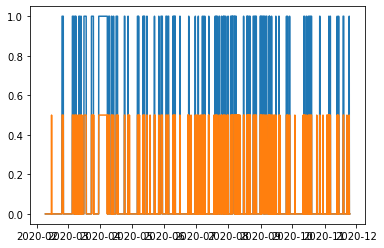

In [132]:
plt.plot(dataframe_pred_test['sde_eventN_N11predicted'])
plt.plot(dataframe_pred_test['sde_eventN_N11']*0.5)

In [161]:
result = metric_sde(df_dates_new, dataframe_pred_test, multivariate = False)

In [162]:
result.sort_values('TP', axis = 1, ascending = False)

AE_neg  BsR_S12  BsG_S12  BbsB_S12  BbsR_S12  babs_450  BsB_S12  \
#sde_truth        26       26       26        26        26        26       26   
#nosde_truth      25       25       25        25        25        25       25   
#sde_pred         35       87       92       106       105       103       94   
#nosde_pred       34       88       93       107       106       104       95   
TP                25       20       19        19        19        19       18   
FN                 1        6        7         7         7         7        8   
TN                 0        6        6         5         6         4        6   
FP                25       19       19        20        19        21       19   

              babs_550  BaCorr1_A13  BaCorr7_A13  ...  BaCorr3_A13  \
#sde_truth          26           26           26  ...           26   
#nosde_truth        25           25           25  ...           25   
#sde_pred          103           92           94  ...           95   
#nosde_pred        104           93           95  ...           96   
TP                  18           17           17  ...           17   
FN                   8            9            9  ...            9   
TN                   4            5            4  ...            4   
FP                  21           20           21  ...           21   

              BaCorr2_A13  BbsG_S12  babs_700  N_N11  SSA_550  AAE  AE_SSA  \
#sde_truth             26        26        26     26       26   26      26   
#nosde_truth           25        25        25     25       25   25      25   
#sde_pred              93       108       103     84       69   76      50   
#nosde_pred            94       109       104     85       70   77      51   
TP                     17        17        16     16       14   13      13   
FN                      9         9        10     10       12   13      13   
TN                      5         5         4      6        7   10      14   
FP                     20        20        21     19       18   15      11   

              SSA_700  SSA_450  
#sde_truth         26       26  
#nosde_truth       25       25  
#sde_pred          65       71  
#nosde_pred        66       72  
TP                 12       10  
FN                 14       16  
TN                 13       12  
FP                 12       13  

[8 rows x 23 columns]

In [160]:
def acc_prec_rec(result):
    # accuracy = proportion of true results among the total number of cases examined        
    result.loc['accuracy',:] = (result.loc['TP']+result.loc['TN'])/(result.loc['TP']+result.loc['FP']+result.loc['FN']+result.loc['TN'])

    # precision = what proportion of predicted Positives is truly positive   
    result.loc['precision',:] = result.loc['TP']/(result.loc['TP']+result.loc['FP'])
    
    
    #recall = what proportion of actual Positives is correctly classified (= True positive rate)
    # = sensitivity
    result.loc['recall',:] = result.loc['TP']/(result.loc['TP']+result.loc['FN'])
    
    #specificity (=False positive rate)
    result.loc['specificity',:] = result.loc['TN']/(result.loc['TN'] + result.loc['FP'])


    # F1 score: number between 0 and 1, harmonic mean of precision and recall
    result.loc['F1',:] =2* result.loc['precision']*result.loc['recall']/(result.loc['precision']+result.loc['recall'])
   # confusion_matrix = [[TP, FP],[FN,TN]]
   # print(confusion_matrix)

   # print(np.array(confusion_matrix).sum(axis = 1))
   # if 
   # confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
    
    #print('accuracy: ', accuracy)
    #print('precision: ', precision)
    #print('sensitivity (recall): ', recall)
    #print('specificity: ', specificity)
    #print('F1: ',F1)
    return result #, confusion_matrix    



In [163]:
result = acc_prec_rec(result)

In [164]:
result

N_N11    BsB_S12    BsG_S12    BsR_S12    BbsB_S12  \
#sde_truth    26.000000  26.000000  26.000000  26.000000   26.000000   
#nosde_truth  25.000000  25.000000  25.000000  25.000000   25.000000   
#sde_pred     84.000000  94.000000  92.000000  87.000000  106.000000   
#nosde_pred   85.000000  95.000000  93.000000  88.000000  107.000000   
TP            16.000000  18.000000  19.000000  20.000000   19.000000   
FN            10.000000   8.000000   7.000000   6.000000    7.000000   
TN             6.000000   6.000000   6.000000   6.000000    5.000000   
FP            19.000000  19.000000  19.000000  19.000000   20.000000   
accuracy       0.431373   0.470588   0.490196   0.509804    0.470588   
precision      0.457143   0.486486   0.500000   0.512821    0.487179   
recall         0.615385   0.692308   0.730769   0.769231    0.730769   
specificity    0.240000   0.240000   0.240000   0.240000    0.200000   
F1             0.524590   0.571429   0.593750   0.615385    0.584615   

                BbsG_S12    BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  \
#sde_truth     26.000000   26.000000    26.000000    26.000000    26.000000   
#nosde_truth   25.000000   25.000000    25.000000    25.000000    25.000000   
#sde_pred     108.000000  105.000000    93.000000    95.000000    97.000000   
#nosde_pred   109.000000  106.000000    94.000000    96.000000    98.000000   
TP             17.000000   19.000000    17.000000    17.000000    17.000000   
FN              9.000000    7.000000     9.000000     9.000000     9.000000   
TN              5.000000    6.000000     5.000000     4.000000     5.000000   
FP             20.000000   19.000000    20.000000    21.000000    20.000000   
accuracy        0.431373    0.490196     0.431373     0.411765     0.431373   
precision       0.459459    0.500000     0.459459     0.447368     0.459459   
recall          0.653846    0.730769     0.653846     0.653846     0.653846   
specificity     0.200000    0.240000     0.200000     0.160000     0.200000   
F1              0.539683    0.593750     0.539683     0.531250     0.539683   

              ...  BaCorr1_A13        AAE    babs_450    babs_550    babs_700  \
#sde_truth    ...    26.000000  26.000000   26.000000   26.000000   26.000000   
#nosde_truth  ...    25.000000  25.000000   25.000000   25.000000   25.000000   
#sde_pred     ...    92.000000  76.000000  103.000000  103.000000  103.000000   
#nosde_pred   ...    93.000000  77.000000  104.000000  104.000000  104.000000   
TP            ...    17.000000  13.000000   19.000000   18.000000   16.000000   
FN            ...     9.000000  13.000000    7.000000    8.000000   10.000000   
TN            ...     5.000000  10.000000    4.000000    4.000000    4.000000   
FP            ...    20.000000  15.000000   21.000000   21.000000   21.000000   
accuracy      ...     0.431373   0.450980    0.450980    0.431373    0.392157   
precision     ...     0.459459   0.464286    0.475000    0.461538    0.432432   
recall        ...     0.653846   0.500000    0.730769    0.692308    0.615385   
specificity   ...     0.200000   0.400000    0.160000    0.160000    0.160000   
F1            ...     0.539683   0.481481    0.575758    0.553846    0.507937   

                SSA_450    SSA_550    SSA_700     AE_SSA     AE_neg  
#sde_truth    26.000000  26.000000  26.000000  26.000000  26.000000  
#nosde_truth  25.000000  25.000000  25.000000  25.000000  25.000000  
#sde_pred     71.000000  69.000000  65.000000  50.000000  35.000000  
#nosde_pred   72.000000  70.000000  66.000000  51.000000  34.000000  
TP            10.000000  14.000000  12.000000  13.000000  25.000000  
FN            16.000000  12.000000  14.000000  13.000000   1.000000  
TN            12.000000   7.000000  13.000000  14.000000   0.000000  
FP            13.000000  18.000000  12.000000  11.000000  25.000000  
accuracy       0.431373   0.411765   0.490196   0.529412   0.490196  
precision      0.434783   0.437500   0.500000   0.541667   0.500000

In [142]:
result

N_N11  BsB_S12  BsG_S12  BsR_S12  BbsB_S12  BbsG_S12  BbsR_S12  \
#sde_truth       26       26       26       26        26        26        26   
#nosde_truth     25       25       25       25        25        25        25   
#sde_pred        84       94       92       87       106       108       105   
#nosde_pred      85       95       93       88       107       109       106   
TP               16       18       19       20        19        17        19   
FN               10        8        7        6         7         9         7   
TN                6        6        6        6         5         5         6   
FP               19       19       19       19        20        20        19   

              BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  ...  BaCorr1_A13  AAE  \
#sde_truth             26           26           26  ...           26   26   
#nosde_truth           25           25           25  ...           25   25   
#sde_pred              93           95           97  ...           92   76   
#nosde_pred            94           96           98  ...           93   77   
TP                     17           17           17  ...           17   13   
FN                      9            9            9  ...            9   13   
TN                      5            4            5  ...            5   10   
FP                     20           21           20  ...           20   15   

              babs_450  babs_550  babs_700  SSA_450  SSA_550  SSA_700  AE_SSA  \
#sde_truth          26        26        26       26       26       26      26   
#nosde_truth        25        25        25       25       25       25      25   
#sde_pred          103       103       103       71       69       65      50   
#nosde_pred        104       104       104       72       70       66      51   
TP                  19        18        16       10       14       12      13   
FN                   7         8        10       16       12       14      13   
TN                   4         4         4       12        7       13      14   
FP                  21        21        21       13       18       12      11   

              AE_neg  
#sde_truth        26  
#nosde_truth      25  
#sde_pred         35  
#nosde_pred       34  
TP                25  
FN                 1  
TN                 0  
FP                25  

[8 rows x 23 columns]

In [146]:
result.loc['accuracy',:] = (result.loc['TP']+result.loc['TN'])/(result.loc['TP']+result.loc['FP']+result.loc['FN']+result.loc['TN'])

In [147]:
result

N_N11    BsB_S12    BsG_S12    BsR_S12    BbsB_S12  \
#sde_truth    26.000000  26.000000  26.000000  26.000000   26.000000   
#nosde_truth  25.000000  25.000000  25.000000  25.000000   25.000000   
#sde_pred     84.000000  94.000000  92.000000  87.000000  106.000000   
#nosde_pred   85.000000  95.000000  93.000000  88.000000  107.000000   
TP            16.000000  18.000000  19.000000  20.000000   19.000000   
FN            10.000000   8.000000   7.000000   6.000000    7.000000   
TN             6.000000   6.000000   6.000000   6.000000    5.000000   
FP            19.000000  19.000000  19.000000  19.000000   20.000000   
accuracy       0.431373   0.470588   0.490196   0.509804    0.470588   

                BbsG_S12    BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  \
#sde_truth     26.000000   26.000000    26.000000    26.000000    26.000000   
#nosde_truth   25.000000   25.000000    25.000000    25.000000    25.000000   
#sde_pred     108.000000  105.000000    93.000000    95.000000    97.000000   
#nosde_pred   109.000000  106.000000    94.000000    96.000000    98.000000   
TP             17.000000   19.000000    17.000000    17.000000    17.000000   
FN              9.000000    7.000000     9.000000     9.000000     9.000000   
TN              5.000000    6.000000     5.000000     4.000000     5.000000   
FP             20.000000   19.000000    20.000000    21.000000    20.000000   
accuracy        0.431373    0.490196     0.431373     0.411765     0.431373   

              ...  BaCorr1_A13       AAE   babs_450    babs_550    babs_700  \
#sde_truth    ...    26.000000  26.00000   26.00000   26.000000   26.000000   
#nosde_truth  ...    25.000000  25.00000   25.00000   25.000000   25.000000   
#sde_pred     ...    92.000000  76.00000  103.00000  103.000000  103.000000   
#nosde_pred   ...    93.000000  77.00000  104.00000  104.000000  104.000000   
TP            ...    17.000000  13.00000   19.00000   18.000000   16.000000   
FN            ...     9.000000  13.00000    7.00000    8.000000   10.000000   
TN            ...     5.000000  10.00000    4.00000    4.000000    4.000000   
FP            ...    20.000000  15.00000   21.00000   21.000000   21.000000   
accuracy      ...     0.431373   0.45098    0.45098    0.431373    0.392157   

                SSA_450    SSA_550    SSA_700     AE_SSA     AE_neg  
#sde_truth    26.000000  26.000000  26.000000  26.000000  26.000000  
#nosde_truth  25.000000  25.000000  25.000000  25.000000  25.000000  
#sde_pred     71.000000  69.000000  65.000000  50.000000  35.000000  
#nosde_pred   72.000000  70.000000  66.000000  51.000000  34.000000  
TP            10.000000  14.000000  12.000000  13.000000  25.000000  
FN            16.000000  12.000000  14.000000  13.000000   1.000000  
TN            12.000000   7.000000  13.000000  14.000000   0.000000  
FP            13.000000  18.000000  12.000000  11.000000  25.000000  
accuracy       0.431373   0.411765   0.490196   0.529412   0.490196  

[9 rows x 23 columns]

In [152]:
result.loc['precision',:] = result.loc['TP']/(result.loc['TP']*0+result.loc['FP']*0)

In [154]:
result.loc['recall',:] = result.loc['TP']/(result.loc['TP']+result.loc['FN'])

In [155]:
result

N_N11    BsB_S12    BsG_S12    BsR_S12    BbsB_S12  \
#sde_truth    26.000000  26.000000  26.000000  26.000000   26.000000   
#nosde_truth  25.000000  25.000000  25.000000  25.000000   25.000000   
#sde_pred     84.000000  94.000000  92.000000  87.000000  106.000000   
#nosde_pred   85.000000  95.000000  93.000000  88.000000  107.000000   
TP            16.000000  18.000000  19.000000  20.000000   19.000000   
FN            10.000000   8.000000   7.000000   6.000000    7.000000   
TN             6.000000   6.000000   6.000000   6.000000    5.000000   
FP            19.000000  19.000000  19.000000  19.000000   20.000000   
accuracy       0.431373   0.470588   0.490196   0.509804    0.470588   
precision           inf        inf        inf        inf         inf   
recall         0.615385   0.692308   0.730769   0.769231    0.730769   

                BbsG_S12    BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  \
#sde_truth     26.000000   26.000000    26.000000    26.000000    26.000000   
#nosde_truth   25.000000   25.000000    25.000000    25.000000    25.000000   
#sde_pred     108.000000  105.000000    93.000000    95.000000    97.000000   
#nosde_pred   109.000000  106.000000    94.000000    96.000000    98.000000   
TP             17.000000   19.000000    17.000000    17.000000    17.000000   
FN              9.000000    7.000000     9.000000     9.000000     9.000000   
TN              5.000000    6.000000     5.000000     4.000000     5.000000   
FP             20.000000   19.000000    20.000000    21.000000    20.000000   
accuracy        0.431373    0.490196     0.431373     0.411765     0.431373   
precision            inf         inf          inf          inf          inf   
recall          0.653846    0.730769     0.653846     0.653846     0.653846   

              ...  BaCorr1_A13       AAE    babs_450    babs_550    babs_700  \
#sde_truth    ...    26.000000  26.00000   26.000000   26.000000   26.000000   
#nosde_truth  ...    25.000000  25.00000   25.000000   25.000000   25.000000   
#sde_pred     ...    92.000000  76.00000  103.000000  103.000000  103.000000   
#nosde_pred   ...    93.000000  77.00000  104.000000  104.000000  104.000000   
TP            ...    17.000000  13.00000   19.000000   18.000000   16.000000   
FN            ...     9.000000  13.00000    7.000000    8.000000   10.000000   
TN            ...     5.000000  10.00000    4.000000    4.000000    4.000000   
FP            ...    20.000000  15.00000   21.000000   21.000000   21.000000   
accuracy      ...     0.431373   0.45098    0.450980    0.431373    0.392157   
precision     ...          inf       inf         inf         inf         inf   
recall        ...     0.653846   0.50000    0.730769    0.692308    0.615385   

                SSA_450    SSA_550    SSA_700     AE_SSA     AE_neg  
#sde_truth    26.000000  26.000000  26.000000  26.000000  26.000000  
#nosde_truth  25.000000  25.000000  25.000000  25.000000  25.000000  
#sde_pred     71.000000  69.000000  65.000000  50.000000  35.000000  
#nosde_pred   72.000000  70.000000  66.000000  51.000000  34.000000  
TP            10.000000  14.000000  12.000000  13.000000  25.000000  
FN            16.000000  12.000000  14.000000  13.000000   1.000000  
TN            12.000000   7.000000  13.000000  14.000000   0.000000  
FP            13.000000  18.000000  12.000000  11.000000  25.000000  
accuracy       0.431373   0.411765   0.490196   0.529412   0.490196  
precision           inf        inf        inf        inf        inf  
recall         0.384615   0.538462   0.461538   0.500000   0.961538  

[11 rows x 23 columns]

In [156]:
result.loc['specificity',:] = result.loc['TN']/(result.loc['TN'] + result.loc['FP'])


In [157]:
result

N_N11    BsB_S12    BsG_S12    BsR_S12    BbsB_S12  \
#sde_truth    26.000000  26.000000  26.000000  26.000000   26.000000   
#nosde_truth  25.000000  25.000000  25.000000  25.000000   25.000000   
#sde_pred     84.000000  94.000000  92.000000  87.000000  106.000000   
#nosde_pred   85.000000  95.000000  93.000000  88.000000  107.000000   
TP            16.000000  18.000000  19.000000  20.000000   19.000000   
FN            10.000000   8.000000   7.000000   6.000000    7.000000   
TN             6.000000   6.000000   6.000000   6.000000    5.000000   
FP            19.000000  19.000000  19.000000  19.000000   20.000000   
accuracy       0.431373   0.470588   0.490196   0.509804    0.470588   
precision           inf        inf        inf        inf         inf   
recall         0.615385   0.692308   0.730769   0.769231    0.730769   
specificity    0.240000   0.240000   0.240000   0.240000    0.200000   

                BbsG_S12    BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  \
#sde_truth     26.000000   26.000000    26.000000    26.000000    26.000000   
#nosde_truth   25.000000   25.000000    25.000000    25.000000    25.000000   
#sde_pred     108.000000  105.000000    93.000000    95.000000    97.000000   
#nosde_pred   109.000000  106.000000    94.000000    96.000000    98.000000   
TP             17.000000   19.000000    17.000000    17.000000    17.000000   
FN              9.000000    7.000000     9.000000     9.000000     9.000000   
TN              5.000000    6.000000     5.000000     4.000000     5.000000   
FP             20.000000   19.000000    20.000000    21.000000    20.000000   
accuracy        0.431373    0.490196     0.431373     0.411765     0.431373   
precision            inf         inf          inf          inf          inf   
recall          0.653846    0.730769     0.653846     0.653846     0.653846   
specificity     0.200000    0.240000     0.200000     0.160000     0.200000   

              ...  BaCorr1_A13       AAE    babs_450    babs_550    babs_700  \
#sde_truth    ...    26.000000  26.00000   26.000000   26.000000   26.000000   
#nosde_truth  ...    25.000000  25.00000   25.000000   25.000000   25.000000   
#sde_pred     ...    92.000000  76.00000  103.000000  103.000000  103.000000   
#nosde_pred   ...    93.000000  77.00000  104.000000  104.000000  104.000000   
TP            ...    17.000000  13.00000   19.000000   18.000000   16.000000   
FN            ...     9.000000  13.00000    7.000000    8.000000   10.000000   
TN            ...     5.000000  10.00000    4.000000    4.000000    4.000000   
FP            ...    20.000000  15.00000   21.000000   21.000000   21.000000   
accuracy      ...     0.431373   0.45098    0.450980    0.431373    0.392157   
precision     ...          inf       inf         inf         inf         inf   
recall        ...     0.653846   0.50000    0.730769    0.692308    0.615385   
specificity   ...     0.200000   0.40000    0.160000    0.160000    0.160000   

                SSA_450    SSA_550    SSA_700     AE_SSA     AE_neg  
#sde_truth    26.000000  26.000000  26.000000  26.000000  26.000000  
#nosde_truth  25.000000  25.000000  25.000000  25.000000  25.000000  
#sde_pred     71.000000  69.000000  65.000000  50.000000  35.000000  
#nosde_pred   72.000000  70.000000  66.000000  51.000000  34.000000  
TP            10.000000  14.000000  12.000000  13.000000  25.000000  
FN            16.000000  12.000000  14.000000  13.000000   1.000000  
TN            12.000000   7.000000  13.000000  14.000000   0.000000  
FP            13.000000  18.000000  12.000000  11.000000  25.000000  
accuracy       0.431373   0.411765   0.490196   0.529412   0.490196  
precision           inf        inf        inf        inf        inf  
recall         0.384615   0.538462   0.461538   0.500000   0.961538  
specificity    0.480000   0.280000   0.520000   0.560000   0.000000  

[12 rows x 23 columns]

In [158]:
    result.loc['F1',:] =2* result.loc['precision']*result.loc['recall']/(result.loc['precision']+result.loc['recall'])
   # confusion_matrix = [[TP, FP],[FN,TN]]



In [159]:
result

N_N11    BsB_S12    BsG_S12    BsR_S12    BbsB_S12  \
#sde_truth    26.000000  26.000000  26.000000  26.000000   26.000000   
#nosde_truth  25.000000  25.000000  25.000000  25.000000   25.000000   
#sde_pred     84.000000  94.000000  92.000000  87.000000  106.000000   
#nosde_pred   85.000000  95.000000  93.000000  88.000000  107.000000   
TP            16.000000  18.000000  19.000000  20.000000   19.000000   
FN            10.000000   8.000000   7.000000   6.000000    7.000000   
TN             6.000000   6.000000   6.000000   6.000000    5.000000   
FP            19.000000  19.000000  19.000000  19.000000   20.000000   
accuracy       0.431373   0.470588   0.490196   0.509804    0.470588   
precision           inf        inf        inf        inf         inf   
recall         0.615385   0.692308   0.730769   0.769231    0.730769   
specificity    0.240000   0.240000   0.240000   0.240000    0.200000   
F1                  NaN        NaN        NaN        NaN         NaN   

                BbsG_S12    BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  \
#sde_truth     26.000000   26.000000    26.000000    26.000000    26.000000   
#nosde_truth   25.000000   25.000000    25.000000    25.000000    25.000000   
#sde_pred     108.000000  105.000000    93.000000    95.000000    97.000000   
#nosde_pred   109.000000  106.000000    94.000000    96.000000    98.000000   
TP             17.000000   19.000000    17.000000    17.000000    17.000000   
FN              9.000000    7.000000     9.000000     9.000000     9.000000   
TN              5.000000    6.000000     5.000000     4.000000     5.000000   
FP             20.000000   19.000000    20.000000    21.000000    20.000000   
accuracy        0.431373    0.490196     0.431373     0.411765     0.431373   
precision            inf         inf          inf          inf          inf   
recall          0.653846    0.730769     0.653846     0.653846     0.653846   
specificity     0.200000    0.240000     0.200000     0.160000     0.200000   
F1                   NaN         NaN          NaN          NaN          NaN   

              ...  BaCorr1_A13       AAE    babs_450    babs_550    babs_700  \
#sde_truth    ...    26.000000  26.00000   26.000000   26.000000   26.000000   
#nosde_truth  ...    25.000000  25.00000   25.000000   25.000000   25.000000   
#sde_pred     ...    92.000000  76.00000  103.000000  103.000000  103.000000   
#nosde_pred   ...    93.000000  77.00000  104.000000  104.000000  104.000000   
TP            ...    17.000000  13.00000   19.000000   18.000000   16.000000   
FN            ...     9.000000  13.00000    7.000000    8.000000   10.000000   
TN            ...     5.000000  10.00000    4.000000    4.000000    4.000000   
FP            ...    20.000000  15.00000   21.000000   21.000000   21.000000   
accuracy      ...     0.431373   0.45098    0.450980    0.431373    0.392157   
precision     ...          inf       inf         inf         inf         inf   
recall        ...     0.653846   0.50000    0.730769    0.692308    0.615385   
specificity   ...     0.200000   0.40000    0.160000    0.160000    0.160000   
F1            ...          NaN       NaN         NaN         NaN         NaN   

                SSA_450    SSA_550    SSA_700     AE_SSA     AE_neg  
#sde_truth    26.000000  26.000000  26.000000  26.000000  26.000000  
#nosde_truth  25.000000  25.000000  25.000000  25.000000  25.000000  
#sde_pred     71.000000  69.000000  65.000000  50.000000  35.000000  
#nosde_pred   72.000000  70.000000  66.000000  51.000000  34.000000  
TP            10.000000  14.000000  12.000000  13.000000  25.000000  
FN            16.000000  12.000000  14.000000  13.000000   1.000000  
TN            12.000000   7.000000  13.000000  14.000000   0.000000  
FP            13.000000  18.000000  12.000000  11.000000  25.000000  
accuracy       0.431373   0.411765   0.490196   0.529412   0.490196  
precision           inf        inf        inf        inf        inf  
recall     